In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)


In [3]:
dataFrame = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv', index_col='date')

In [4]:
imputer = SimpleImputer(missing_values=np.nan) # Handling missing values
dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['pm25']] = target_scaler.fit_transform(dataFrame[['pm25']].to_numpy())
df_scaled = df_scaled.astype(float)


In [5]:
# Single step dataset preparation
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['pm25']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)


In [7]:
# Dataset splitting
SPLIT = 0.8
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [70]:
n_forecast = 5

In [72]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.GRU(30, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(keras.layers.Dropout(0.2))
model_gru.add(keras.layers.Dense(n_forecast, activation='tanh'))
model_gru.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 30)                3420      
                                                                 
 dropout_5 (Dropout)         (None, 30)                0         
                                                                 
 dense_5 (Dense)             (None, 5)                 155       
                                                                 
Total params: 3575 (13.96 KB)
Trainable params: 3575 (13.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
history = model_gru.fit(X_train, y_train, epochs=20, batch_size=12)

Epoch 1/20
127/127 [==============================] - 5s 10ms/step - loss: 0.0320 - MAE: 0.1309
Epoch 2/20
127/127 [==============================] - 1s 11ms/step - loss: 0.0165 - MAE: 0.0945
Epoch 3/20
127/127 [==============================] - 1s 11ms/step - loss: 0.0136 - MAE: 0.0833
Epoch 4/20
127/127 [==============================] - 1s 11ms/step - loss: 0.0124 - MAE: 0.0778
Epoch 5/20
127/127 [==============================] - 2s 13ms/step - loss: 0.0110 - MAE: 0.0724
Epoch 6/20
127/127 [==============================] - 2s 15ms/step - loss: 0.0111 - MAE: 0.0712
Epoch 7/20
127/127 [==============================] - 2s 15ms/step - loss: 0.0100 - MAE: 0.0669
Epoch 8/20
127/127 [==============================] - 2s 13ms/step - loss: 0.0102 - MAE: 0.0659
Epoch 9/20
127/127 [==============================] - 1s 10ms/step - loss: 0.0096 - MAE: 0.0631
Epoch 10/20
127/127 [==============================] - 1s 10ms/step - loss: 0.0093 - MAE: 0.0620
Epoch 11/20
127/127 [==================

In [74]:
# Reload the data with the date index
dataFrame = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv') # Assuming the CSV file contains a 'Date' column
dataFrame['date'] = pd.to_datetime(dataFrame['date'])
dataFrame.set_index('date', inplace=True)

# Forecast Plot with Dates on X-axis
predicted_values = model_gru.predict(X_test)

d = {
	'Predicted_pm25': predicted_values[:, 0],
 'Actual_pm25': y_test[:, 0],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):] # Assigning the correct date index


12/12 [==============================] - 1s 6ms/step


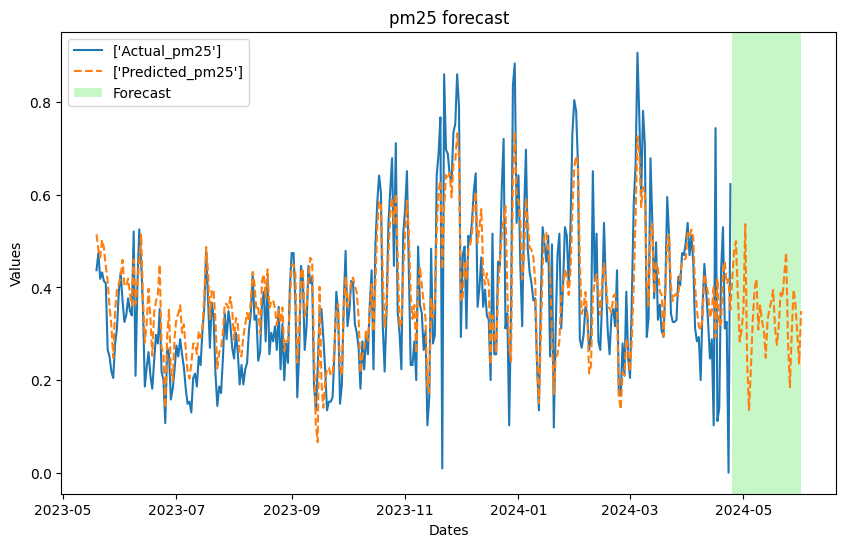

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
# highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1 # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_pm25']][:highlight_start], label=['Actual_pm25'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_pm25']], label=['Predicted_pm25'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('pm25 forecast')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [76]:
predicted_values

array([[0.51489884, 0.5212469 , 0.52473265, 0.52383786, 0.5234864 ],
       [0.4820727 , 0.48394373, 0.48760816, 0.48839915, 0.4808569 ],
       [0.46499315, 0.47158745, 0.46989402, 0.47098708, 0.46561518],
       ...,
       [0.2991405 , 0.2911121 , 0.300365  , 0.30323067, 0.29737085],
       [0.23600042, 0.22996835, 0.23897552, 0.24045566, 0.23641136],
       [0.3490069 , 0.34471223, 0.3515624 , 0.35449725, 0.3471137 ]],
      dtype=float32)

In [77]:
predicted_values[:1].size

5

In [83]:
predicted_values_90 = predicted_values[:18]

In [84]:
pm25_scaler = target_scaler
# Perform the inverse transformation on the scaled pm25 data
predicted_values_90 = pm25_scaler.inverse_transform(predicted_values_90)

# Check the DataFrame to see the reversed pm25 values
print(predicted_values_90)

[[112.70325  114.068085 114.81752  114.62514  114.54957 ]
 [105.64563  106.0479   106.835754 107.00581  105.38423 ]
 [101.973526 103.3913   103.027214 103.26222  102.10726 ]
 [110.09453  111.675896 111.73016  110.55418  110.75711 ]
 [106.29086  107.31455  107.54981  108.01459  106.28687 ]
 [ 98.00688   98.85245   98.78036  100.09794   98.072495]
 [ 90.98782   92.98663   93.27405   93.15526   93.28936 ]
 [ 79.2088    79.21056   80.34834   81.44675   80.05895 ]
 [ 70.29187   70.14254   71.13049   72.50848   70.23626 ]
 [ 55.327404  55.256397  55.845318  57.089897  55.309395]
 [ 77.46866   78.120544  78.85297   78.22479   77.81559 ]
 [ 86.97144   87.31165   88.07502   88.30988   87.41265 ]
 [ 89.64674   89.46306   90.098145  91.10224   89.637924]
 [ 92.91704   93.62648   94.175964  94.09854   93.19063 ]
 [100.83852  102.50395  103.0145   101.789345 102.17924 ]
 [ 88.693405  88.710075  88.763916  90.918144  88.66863 ]
 [ 88.89467   88.90948   89.09362   90.56928   88.86459 ]
 [ 92.158646  

In [85]:
predicted_values_90 = np.concatenate(predicted_values_90, axis=0)

In [86]:
predicted_values_90.size

90

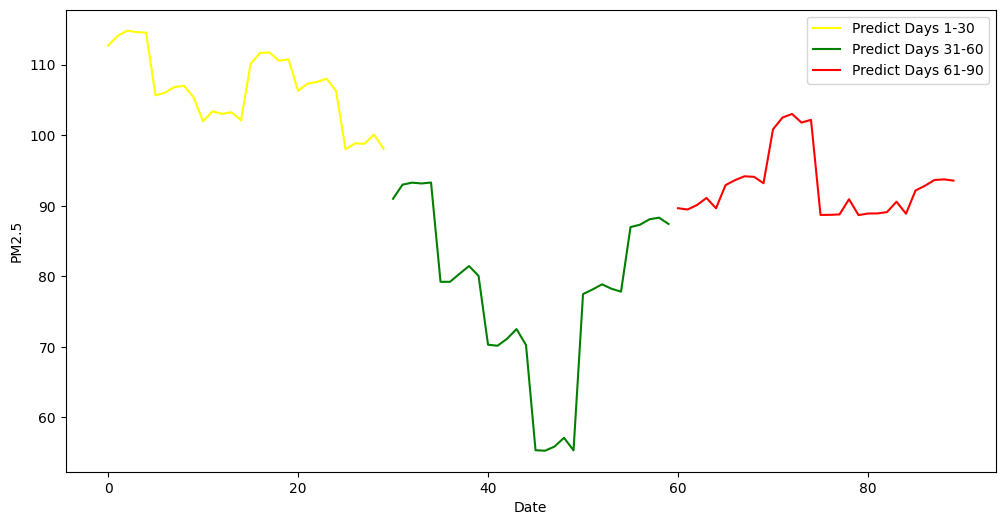

In [87]:
plt.figure(figsize=(12, 6))

dates = np.arange(1, 91)
data = pd.DataFrame({'Date': dates, 'predicted_values_90': predicted_values_90})

plt.plot(data['predicted_values_90'][:30], color='yellow', label='Predict Days 1-30')
plt.plot(data['predicted_values_90'][30:60], color='green', label='Predict Days 31-60')
plt.plot(data['predicted_values_90'][60:], color='red', label='Predict Days 61-90')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()

# Show plot
plt.show()

In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
if predicted_values.ndim == 1:
    predicted_values = predicted_values.reshape(-1, 1)

# Inverse transform the predicted values
predicted_values_all = pm25_scaler.inverse_transform(predicted_values)

# Check the shape after inverse transformation
print("Shape of y_test:", y_test.shape)
print("Shape of predicted_values_all:", predicted_values_all.shape)
# Aggregate predictions to match the shape of y_test
predicted_values_aggregated = np.mean(predicted_values_all, axis=1, keepdims=True)

# Calculate the RMSE, MAE, and MAPE
rmse = mean_squared_error(y_test, predicted_values_aggregated, squared=False)
mae = mean_absolute_error(y_test, predicted_values_aggregated)
mape = mean_absolute_percentage_error(y_test, predicted_values_aggregated)

# Print the results
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)


Shape of y_test: (380, 1)
Shape of predicted_values_all: (380, 5)
RMSE: 88.46256334323745
MAE: 84.80816893053463
MAPE: 1087575416348693.5
